In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
''' Activation Functions '''

def relu(x, p=False):
    if p: return 1 * (x > 0)
    return x * (x > 0)

def linear(x, p=False):
    if p: return np.ones_like(x)
    return x

In [14]:
''' Cost Functions '''

def MSE(output_acts, y, p=False):
    if p: return (output_acts-y)
    return 0.5*(output_acts-y)**2

def MAE(output_acts, y, p=False):
    if p: return np.sign(output_acts-y) #zero ??
    return np.abs(output_acts-y)

def logcosh(output_acts, y, p=False):
    error = (output_acts-y)
    if p: return np.sinh(error) / np.cosh(error)
    return np.log(np.cosh(error))

def huber(output_acts, y, delta=1.0, p=False):
    huber_mse = MSE(output_acts, y, p)
    huber_mae = delta * (MAE(output_acts, y, p) - (0.5 * delta)*(not p)) # delta*(+-1)
    return np.where(np.abs(output_acts - y) <= delta, huber_mse, huber_mae)

In [4]:
''' Optimizer Class '''

class Optimizer:

    def __init__(self, name, args):
        self.name = name
        self.args = args
        self.eps = 1e-8
        self.lr = 0

    def initialize(self, vars):
        if self.name in 'sgd':
            self.momentum = [np.zeros(v.shape) for v in vars]
        
        if self.name == 'adagrad':
            self.second_moment = [np.zeros(v.shape) for v in vars]

        if self.name == 'rmsprop':
            self.second_moment = [np.zeros(v.shape) for v in vars]

        if self.name == 'adadelta':
            self.second_moment = [np.zeros(v.shape) for v in vars]
            self.second_moment_updates = [np.zeros(v.shape) for v in vars]

        if self.name == 'adam':
            self.t = 1 
            self.first_moment = [np.zeros(v.shape) for v in vars]
            self.second_moment = [np.zeros(v.shape) for v in vars]
        
    def set_lr(self, lr):
        self.lr = lr

    def update(self, var, nabla):
        if self.name == 'sgd':
            alpha = self.args['alpha']
            self.momentum = [alpha*m + self.lr*n 
                            for m, n in zip(self.momentum, nabla)]
            var = [v - m for v, m in zip(var, self.momentum)]

        elif self.name == 'adagrad':
            self.second_moment = [g + n**2 
                                  for g, n in zip(self.second_moment, nabla)]
            var = [v - (n*self.lr)/(np.sqrt(g) + self.eps)
                    for v, n, g in zip(var, nabla, self.second_moment)]                      

        elif self.name == 'rmsprop':
            decay_rate = self.args['decay_rate']
            self.second_moment = [decay_rate * m + (1-decay_rate) * (n**2)
                                  for m, n in zip(self.second_moment, nabla)]
            var = [v - (n*self.lr)/(np.sqrt(g) + self.eps)
                    for v, n, g in zip(var, nabla, self.second_moment)] 
        
        elif self.name == 'adadelta':
            decay_rate = self.args['decay_rate']
            self.second_moment = [decay_rate * m + (1-decay_rate) * (n**2)
                                  for m, n in zip(self.second_moment, nabla)]
            updates = [((np.sqrt(u) + self.eps)*n)/(np.sqrt(g) + self.eps)
                    for n, u, g in zip(nabla, self.second_moment_updates, self.second_moment)]
            var = [v - u for v, u in zip(var, updates)]
            self.second_moment_updates = [decay_rate * m + (1-decay_rate) * (u**2)
                                          for m, u in zip(self.second_moment_updates, updates)]

        elif self.name == 'adam':
            beta1 = self.args['beta1']
            beta2 = self.args['beta2']
            self.t += 1
            self.first_moment = [beta1 * m + (1-beta1) * n
                                  for m, n in zip(self.first_moment, nabla)]
            self.second_moment = [beta2 * m + (1-beta2) * (n**2)
                                  for m, n in zip(self.second_moment, nabla)]
            fm_hat = [m/(1-(beta1**self.t)) for m in self.first_moment]
            sm_hat = [m/(1-(beta2**self.t)) for m in self.second_moment]
            var = [v - (m*self.lr)/(np.sqrt(g) + self.eps)
                    for v, m, g in zip(var, fm_hat, sm_hat)]

        return var

In [5]:
''' Learning Rate Schedulers '''

def constant(lr, epoch):
    return lr

def time_decay(lr, epoch, decay_rate):
    return lr / (1. + decay_rate*epoch)

def exp_decay(lr, epoch, decay_rate):
    return lr * np.exp(-epoch*decay_rate)

def step_decay(lr, epoch, decay_rate, decay_step):
    return lr * decay_rate**(np.floor(epoch/decay_step))

In [6]:
''' Network Class '''

class Network:

    def __init__(self, s=43):
        np.random.seed(s)
        self.layer_cnt = 0
        self.weights = []
        self.biases = []
        self.act_funcs = []
        self.report = dict()
        self.report['loss'] = []
        self.report['re'] = []

    def dense(self, neuron_cnt, act_func, input_shape=None):
        if self.layer_cnt == 0 and (not input_shape):
            raise Exception('First Layer Must Have Input Shape')

        self.layer_cnt += 1

        if self.layer_cnt == 1:
            self.weights.append(np.random.normal(0, 0.05, (neuron_cnt, input_shape)))
        else:
            self.weights.append(np.random.normal(0, 0.05, (neuron_cnt, self.weights[-1].shape[0])))

        self.biases.append(np.zeros((neuron_cnt, 1)))
        self.act_funcs.append(act_func)

    def feedforward(self, x):
        pre_acts, acts = [], []
        act = np.array(x)

        acts.append(act)

        for w, b, a in zip(self.weights, self.biases, self.act_funcs):
            pre_act = np.dot(w, act) + b
            act = a(pre_act)
            pre_acts.append(pre_act)
            acts.append(act)

        return pre_acts, acts, act

    def backprop(self, x, y, cost_func):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        pre_acts, acts, out = self.feedforward(x)

        delta = cost_func(acts[-1], y, p=True) * self.act_funcs[-1](pre_acts[-1], p=True)
        nabla_w[-1] = np.dot(delta, acts[-2].T)
        nabla_b[-1] = delta

        for i in range(2, self.layer_cnt+1):
            delta = np.dot(self.weights[-i+1].T, delta) * self.act_funcs[-i](pre_acts[-i], p=True)
            nabla_w[-i] = np.dot(delta, acts[-i-1].T)
            nabla_b[-i] = delta

        return nabla_w, nabla_b, out

    def next_mini_batch(self, dataset, batch_size):
        N = dataset['count']
        indxs = np.arange(N)
        np.random.shuffle(indxs)

        for i in range(0, N-batch_size+1, batch_size):
            mini_batch = indxs[i:i+batch_size]
            yield zip(dataset['X'][mini_batch], dataset['y'][mini_batch])

    def learn(self, cost_func, epochs, dataset,
            opt_args, lr_schedulers, nasterov=False,
            eta=0.001, alpha=0.9, batch_size=32, verbos=1):
        
        optimizer_b = Optimizer(*opt_args)
        optimizer_w = Optimizer(*opt_args)
        optimizer_b.initialize(self.biases)
        optimizer_w.initialize(self.weights)

        for i in tqdm(range(epochs), disable=(not verbos)):
            eta_ = lr_schedulers(eta, i)
            lr = eta_/batch_size
            optimizer_b.set_lr(lr)
            optimizer_w.set_lr(lr)

            y_, y_h = [], []

            for mini_batch in self.next_mini_batch(dataset, batch_size):
                nabla_b = [np.zeros(b.shape) for b in self.biases]
                nabla_w = [np.zeros(w.shape) for w in self.weights]

                if nasterov:
                    self.biases = [b + alpha*m 
                                   for b, m in zip(self.biases, optimizer_b.momentum)]
                    self.weights = [w + alpha*m 
                                    for w, m in zip(self.weights, optimizer_w.momentum)]

                for x, y in mini_batch:
                    delta_nabla_w, delta_nabla_b, out = self.backprop(x, y, cost_func)
                    nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)] 
                    nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
                    y_.append(y)
                    y_h.append(out)

                self.biases = optimizer_b.update(self.biases, nabla_b)
                self.weights =  optimizer_w.update(self.weights, nabla_w)

            y_, y_h = np.array(y_).ravel(), np.array(y_h).ravel()
            self.report['loss'].append(np.mean(cost_func(y_h, y_)))
            self.report['re'].append(np.mean(np.abs((y_h-y_)/y_)))

            if verbos == 1:
                print('loss: ', self.report['loss'][-1],
                      'reletive error: ', self.report['re'][-1])

    def reset(self):
        self.biases = [np.random.rand(*b.shape) for b in self.biases]
        self.weights = [np.random.rand(*w.shape) for w in self.weights]
        self.report['loss'] = []
        self.report['re'] = []

In [7]:
''' Dataset Functions '''

def make_dataset(N, outlier_chance):
    dataset = dict()
    dataset['count'] = N
    dataset['X'] = np.random.uniform(-1, 1, (N, 10, 1))
    dataset['y'] = np.sin(np.mean(dataset['X'][:, :5], axis=1)) + \
                    np.cos(np.mean(dataset['X'][:, 5:], axis=1))
    outlier_mask = np.ones_like(dataset['y']) * (np.random.rand(N, 1) < outlier_chance)
    dataset['y'] = dataset['y'] + np.random.normal(0, 10, (N, 1))*outlier_mask

    return dataset

  2%|▏         | 1/50 [00:00<00:44,  1.09it/s]

loss:  82.99714756804728 reletive error:  80.75235984471529


  4%|▍         | 2/50 [00:01<00:44,  1.09it/s]

loss:  66.93900376572724 reletive error:  65.14525617929871


  6%|▌         | 3/50 [00:02<00:43,  1.08it/s]

loss:  53.59014598471642 reletive error:  52.21437479321532


  8%|▊         | 4/50 [00:03<00:42,  1.08it/s]

loss:  42.257771650376895 reletive error:  41.24015712421937


 10%|█         | 5/50 [00:04<00:41,  1.09it/s]

loss:  32.53170342599437 reletive error:  31.807260529339406


 12%|█▏        | 6/50 [00:05<00:40,  1.07it/s]

loss:  24.09879473696789 reletive error:  23.64705900635854


 14%|█▍        | 7/50 [00:06<00:40,  1.07it/s]

loss:  16.709553833471567 reletive error:  16.510600477443415


 16%|█▌        | 8/50 [00:07<00:39,  1.06it/s]

loss:  10.142124587231015 reletive error:  10.155844931342987


 18%|█▊        | 9/50 [00:08<00:38,  1.07it/s]

loss:  4.3357473206552415 reletive error:  4.488966513846775


 20%|██        | 10/50 [00:09<00:37,  1.07it/s]

loss:  0.660199125585748 reletive error:  1.0277760416584745


 22%|██▏       | 11/50 [00:10<00:36,  1.06it/s]

loss:  0.23597921870286082 reletive error:  0.6207499163256578


 24%|██▍       | 12/50 [00:11<00:35,  1.06it/s]

loss:  0.13450910241230937 reletive error:  0.4471731081856368


 26%|██▌       | 13/50 [00:12<00:35,  1.06it/s]

loss:  0.0695112672308307 reletive error:  0.31421107927769265


 28%|██▊       | 14/50 [00:13<00:34,  1.05it/s]

loss:  0.03555838450487739 reletive error:  0.22990760409232708


 30%|███       | 15/50 [00:14<00:33,  1.06it/s]

loss:  0.02021586224781498 reletive error:  0.1827068498421644


 32%|███▏      | 16/50 [00:15<00:32,  1.06it/s]

loss:  0.013619257050100171 reletive error:  0.1554562253519179


 34%|███▍      | 17/50 [00:15<00:30,  1.07it/s]

loss:  0.01064574251569468 reletive error:  0.13872348834572293


 36%|███▌      | 18/50 [00:16<00:29,  1.08it/s]

loss:  0.009108433556566407 reletive error:  0.12760066104320955


 38%|███▊      | 19/50 [00:17<00:28,  1.08it/s]

loss:  0.008076349061348959 reletive error:  0.11949209913121285


 40%|████      | 20/50 [00:18<00:27,  1.09it/s]

loss:  0.007241073428280034 reletive error:  0.11272865792658021


 42%|████▏     | 21/50 [00:19<00:26,  1.09it/s]

loss:  0.0064802410239001755 reletive error:  0.10626937695788842


 44%|████▍     | 22/50 [00:20<00:25,  1.09it/s]

loss:  0.005805696020150527 reletive error:  0.1003658259011773


 46%|████▌     | 23/50 [00:21<00:24,  1.09it/s]

loss:  0.005202992924742369 reletive error:  0.09501527285726682


 48%|████▊     | 24/50 [00:22<00:23,  1.09it/s]

loss:  0.004644637548086343 reletive error:  0.08980863671012294


 50%|█████     | 25/50 [00:23<00:23,  1.08it/s]

loss:  0.004173586339730002 reletive error:  0.08510026189072398


 52%|█████▏    | 26/50 [00:24<00:22,  1.08it/s]

loss:  0.003760458877674953 reletive error:  0.08051513065669254


 54%|█████▍    | 27/50 [00:25<00:21,  1.08it/s]

loss:  0.003409770281417459 reletive error:  0.07666343091474531


 56%|█████▌    | 28/50 [00:26<00:20,  1.08it/s]

loss:  0.003092997707586615 reletive error:  0.07261555823932796


 58%|█████▊    | 29/50 [00:26<00:19,  1.08it/s]

loss:  0.0028313377242842937 reletive error:  0.0693727201009948


 60%|██████    | 30/50 [00:27<00:18,  1.08it/s]

loss:  0.002595612800062429 reletive error:  0.06610683241347803


 62%|██████▏   | 31/50 [00:28<00:17,  1.08it/s]

loss:  0.0023976743002140323 reletive error:  0.06318887669148648


 64%|██████▍   | 32/50 [00:29<00:16,  1.09it/s]

loss:  0.0022177725860836927 reletive error:  0.060541649574326756


 66%|██████▌   | 33/50 [00:30<00:15,  1.08it/s]

loss:  0.002061710232294225 reletive error:  0.058200455000339955


 68%|██████▊   | 34/50 [00:31<00:14,  1.08it/s]

loss:  0.001920680158783568 reletive error:  0.055990769325425085


 70%|███████   | 35/50 [00:32<00:13,  1.08it/s]

loss:  0.0017929788051886896 reletive error:  0.053880024372529804


 72%|███████▏  | 36/50 [00:33<00:13,  1.06it/s]

loss:  0.0016696787470328726 reletive error:  0.051824317628819075


 74%|███████▍  | 37/50 [00:34<00:12,  1.04it/s]

loss:  0.001559856098928732 reletive error:  0.05014595422065305


 76%|███████▌  | 38/50 [00:35<00:11,  1.03it/s]

loss:  0.0014485889309298705 reletive error:  0.048105715394674425


 78%|███████▊  | 39/50 [00:36<00:10,  1.03it/s]

loss:  0.0013469416168647105 reletive error:  0.046298816357757636


 80%|████████  | 40/50 [00:37<00:09,  1.03it/s]

loss:  0.001256255840297995 reletive error:  0.04469887422788022


 82%|████████▏ | 41/50 [00:38<00:08,  1.04it/s]

loss:  0.001162131679564693 reletive error:  0.04295687338234159


 84%|████████▍ | 42/50 [00:39<00:07,  1.05it/s]

loss:  0.0010736376275557746 reletive error:  0.041056554225911805


 86%|████████▌ | 43/50 [00:40<00:06,  1.05it/s]

loss:  0.00099121651224825 reletive error:  0.03949777514059474


 88%|████████▊ | 44/50 [00:41<00:05,  1.07it/s]

loss:  0.0009136321639884874 reletive error:  0.03781682111915979


 90%|█████████ | 45/50 [00:42<00:04,  1.07it/s]

loss:  0.0008357755093649232 reletive error:  0.036120089294154625


 92%|█████████▏| 46/50 [00:43<00:03,  1.07it/s]

loss:  0.0007721411839186728 reletive error:  0.03469933133320206


 94%|█████████▍| 47/50 [00:44<00:02,  1.05it/s]

loss:  0.0007045213927701052 reletive error:  0.03308850940224647


 96%|█████████▌| 48/50 [00:44<00:01,  1.06it/s]

loss:  0.0006411863243994408 reletive error:  0.031500117055452935


 98%|█████████▊| 49/50 [00:45<00:00,  1.07it/s]

loss:  0.0005854651409091353 reletive error:  0.030107359619222104


  0%|          | 0/50 [00:00<?, ?it/s]

loss:  0.0005327674577056409 reletive error:  0.028717084754164138


  2%|▏         | 1/50 [00:00<00:45,  1.09it/s]

loss:  127.37855721784418 reletive error:  120.59839071387995


  4%|▍         | 2/50 [00:01<00:44,  1.08it/s]

loss:  106.2148768316271 reletive error:  100.67952138268656


  6%|▌         | 3/50 [00:02<00:43,  1.09it/s]

loss:  88.09108219015238 reletive error:  83.56996435957956


  8%|▊         | 4/50 [00:03<00:42,  1.09it/s]

loss:  72.47406450162883 reletive error:  68.80402361236453


 10%|█         | 5/50 [00:04<00:41,  1.09it/s]

loss:  58.85010036351778 reletive error:  55.908708517550224


 12%|█▏        | 6/50 [00:05<00:40,  1.08it/s]

loss:  46.752350949090896 reletive error:  44.51296906857103


 14%|█▍        | 7/50 [00:06<00:40,  1.07it/s]

loss:  35.904517427868015 reletive error:  34.26300212850578


 16%|█▌        | 8/50 [00:07<00:39,  1.05it/s]

loss:  26.130977515100657 reletive error:  25.01231651840719


 18%|█▊        | 9/50 [00:08<00:41,  1.01s/it]

loss:  17.326598491174952 reletive error:  16.696173052486124


 20%|██        | 10/50 [00:10<00:47,  1.18s/it]

loss:  9.361553895444189 reletive error:  9.143246649043494


 22%|██▏       | 11/50 [00:11<00:50,  1.30s/it]

loss:  2.6030871578886843 reletive error:  2.6103797773767705


 24%|██▍       | 12/50 [00:13<00:53,  1.40s/it]

loss:  0.5994488062652185 reletive error:  0.628738472453404


 26%|██▌       | 13/50 [00:15<00:54,  1.47s/it]

loss:  0.48004673720752944 reletive error:  0.4586192456409796


 28%|██▊       | 14/50 [00:16<00:55,  1.55s/it]

loss:  0.42453548701139154 reletive error:  0.3502702291976233


 30%|███       | 15/50 [00:18<00:56,  1.60s/it]

loss:  0.4059104644513174 reletive error:  0.29849699843124855


 32%|███▏      | 16/50 [00:20<00:54,  1.59s/it]

loss:  0.3997230161718279 reletive error:  0.2771205443471107


 34%|███▍      | 17/50 [00:21<00:46,  1.40s/it]

loss:  0.39652704476813716 reletive error:  0.2638410772432181


 36%|███▌      | 18/50 [00:21<00:40,  1.26s/it]

loss:  0.3938536048708905 reletive error:  0.25125247650864785


 38%|███▊      | 19/50 [00:22<00:35,  1.15s/it]

loss:  0.3914085350146822 reletive error:  0.2382868634951255


 40%|████      | 20/50 [00:23<00:32,  1.09s/it]

loss:  0.3893527796907265 reletive error:  0.22583920048099848


 42%|████▏     | 21/50 [00:24<00:30,  1.05s/it]

loss:  0.38758919973799427 reletive error:  0.21506202351465914


 44%|████▍     | 22/50 [00:25<00:28,  1.01s/it]

loss:  0.3862419499753744 reletive error:  0.20578992969606053


 46%|████▌     | 23/50 [00:26<00:26,  1.02it/s]

loss:  0.38499420729345274 reletive error:  0.19699113820024258


 48%|████▊     | 24/50 [00:27<00:25,  1.04it/s]

loss:  0.384108062924208 reletive error:  0.19019478310200513


 50%|█████     | 25/50 [00:28<00:23,  1.04it/s]

loss:  0.38338621099042874 reletive error:  0.18360851392205024


 52%|█████▏    | 26/50 [00:29<00:22,  1.06it/s]

loss:  0.3827132952178453 reletive error:  0.17763523466061962


 54%|█████▍    | 27/50 [00:30<00:21,  1.07it/s]

loss:  0.38220139073046816 reletive error:  0.17356435380864732


 56%|█████▌    | 28/50 [00:31<00:20,  1.07it/s]

loss:  0.3819016068433846 reletive error:  0.17072017345979917


 58%|█████▊    | 29/50 [00:32<00:19,  1.08it/s]

loss:  0.3814719091244207 reletive error:  0.1672962969393681


 60%|██████    | 30/50 [00:33<00:18,  1.07it/s]

loss:  0.38119559433384054 reletive error:  0.16404043798273069


 62%|██████▏   | 31/50 [00:33<00:17,  1.08it/s]

loss:  0.38094508093366475 reletive error:  0.16153239916199985


 64%|██████▍   | 32/50 [00:34<00:16,  1.08it/s]

loss:  0.3807721468953049 reletive error:  0.1602089306010702


 66%|██████▌   | 33/50 [00:35<00:15,  1.08it/s]

loss:  0.380540082922693 reletive error:  0.1571814186228238


 68%|██████▊   | 34/50 [00:36<00:14,  1.08it/s]

loss:  0.3804396369606637 reletive error:  0.1566531620806036


 70%|███████   | 35/50 [00:37<00:13,  1.09it/s]

loss:  0.38017626582517944 reletive error:  0.15455812262011362


 72%|███████▏  | 36/50 [00:38<00:13,  1.07it/s]

loss:  0.38009850609409945 reletive error:  0.15207223298319847


 74%|███████▍  | 37/50 [00:39<00:12,  1.08it/s]

loss:  0.3800405132280049 reletive error:  0.151068457252994


 76%|███████▌  | 38/50 [00:40<00:11,  1.08it/s]

loss:  0.3799041013005383 reletive error:  0.15005974759028767


 78%|███████▊  | 39/50 [00:41<00:10,  1.08it/s]

loss:  0.3797912994216938 reletive error:  0.14961442764438598


 80%|████████  | 40/50 [00:42<00:09,  1.08it/s]

loss:  0.3796809504330719 reletive error:  0.1489578414881359


 82%|████████▏ | 41/50 [00:43<00:08,  1.08it/s]

loss:  0.37966911908574763 reletive error:  0.149332023558015


 84%|████████▍ | 42/50 [00:44<00:07,  1.08it/s]

loss:  0.37954511670180535 reletive error:  0.147303441959839


 86%|████████▌ | 43/50 [00:45<00:06,  1.09it/s]

loss:  0.3795105275001304 reletive error:  0.14652054361987712


 88%|████████▊ | 44/50 [00:45<00:05,  1.09it/s]

loss:  0.37942939693201483 reletive error:  0.1452859466942942


 90%|█████████ | 45/50 [00:46<00:04,  1.09it/s]

loss:  0.37932490178511924 reletive error:  0.14422889380395842


 92%|█████████▏| 46/50 [00:47<00:03,  1.09it/s]

loss:  0.37932310537304037 reletive error:  0.14381738161965776


 94%|█████████▍| 47/50 [00:48<00:02,  1.06it/s]

loss:  0.3792409398129915 reletive error:  0.1432405427511413


 96%|█████████▌| 48/50 [00:49<00:01,  1.04it/s]

loss:  0.37918801035525224 reletive error:  0.1433024383816851


 98%|█████████▊| 49/50 [00:50<00:00,  1.04it/s]

loss:  0.3791313247408193 reletive error:  0.140681329282596


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]

loss:  0.3790451740789718 reletive error:  0.14124676879944428


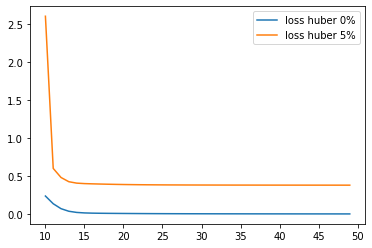

In [15]:
x = np.arange(10, 50)

mynet = Network()

mynet.dense(16, relu, 10)
mynet.dense(32, relu)
mynet.dense(1, linear)

lr_schedulers = lambda lr, epoch: constant(lr, epoch)
optimizer = ('adam', {'beta1':0.9, 'beta2':0.999})

mydata = make_dataset(10000, 0.0)
mynet.reset()
mynet.learn(huber, 50, mydata, optimizer, lr_schedulers, nasterov=False,
            eta=0.001, batch_size=16, alpha=0.9, verbos=1)
plt.plot(x, mynet.report['loss'][10:], label="loss huber 0%")

mydata = make_dataset(10000, 0.05)
mynet.reset()
mynet.learn(huber, 50, mydata, optimizer, lr_schedulers, nasterov=False,
            eta=0.001, batch_size=16, alpha=0.9, verbos=1)
plt.plot(x, mynet.report['loss'][10:], label="loss huber 5%")


plt.legend()
plt.show()